I have an idea that by changing the probability density function (pdf) of attack damage as a funciton of player level, I can make it so that the player will roll consistently higher damage at higher levels. The following is a simple proof of concept, based on the idea of a pdf that is shaped like a first order polynomial.

To figure out the formula I need, I need to find alpha and beta, such that if
$$pdf(x)=\alpha x + \beta$$
then
$$\int_d^D (\alpha x + \beta)\ dx = 1$$
where d is the minimum possible damage and D is the maximum possible damage.

However, after doing some math, I came up with this:
$$\alpha(D^2-d^2)+2\beta(D-d)=2$$

And I realized that it would be a lot easier to just pretend that beta is zero for now. It's not very mathematically rigorous, but as long as it works well enough, it's good enough to put into a game. Does it work well enough? Let's find out! With this substitution, the equation looks more like this:

$$\alpha(D^2-d^2)=2$$

Which very easily reduces to:

$$\alpha=\frac{2}{D^2-d^2}$$

Now that we have alpha, I can write the pdf as:

$$pdf(x)=(\frac{2}{D^2-d^2})x$$

I need to use this to come up with a function that will give the the rolled damage as a function of a random roll between 0 and 1. Here's my idea for this: cdf(x) gives me the probability that the rolled damage was between the minimum damage and x. In my mind, that means it might work to take the integral of the pdf from the minimum damage to some rolled damage $D_r$ with respect to x, which in this case represents damage. The value of this integral should be the probability that rolled damage is less than or equal to $D_r$. I can rearrange the resulting equation to give $D_r$ as a function of the probability $p$. This will serve as my formula to get randomized damage from a given random roll $r$, which I will simply swap in for $p$, which I'm pretty sure will work. Let's try it:

$$\int_d^{D_r}(\alpha x)\ dx =\ p =\ r$$


$$\frac{1}{2}\alpha x^2\rvert_d^{D_r} = r$$

$$\frac{1}{2}\alpha (D_r^2-d^2) = r$$

Solved for $D_r$:

$$D_r=\sqrt{d^2+\frac{2r}{\alpha}}$$

Before I try this function out, let's do a quick sanity check. What I expect is that if $r = 0$, then $D_r = d$, and if $r = 1$, then $D_r = D$. Does this bear out? Note:
$$\frac{2}{\alpha} = D^2 - d^2$$

So if r = 1:

$$D_r=\sqrt{d^2+\frac{2}{\alpha}}$$

$$D_r = \sqrt{d^2 + D^2 - d^2}$$

$$D_r = D$$

Looking good so far! How about when $r = 0$?

$$D_r=\sqrt{d^2+(\frac{2}{\alpha})*0}$$

$$D_r=\sqrt{d^2}$$

$$D_r=d$$

Nice! It looks like my assumptions haven't been too far off yet. Now I'm going to graph this to be sure.

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import random as random

In [11]:
# Setting up some variables
seed = 628
random.seed = seed

samples = 10000


In [12]:
# Set up some some testing helpers

# I'm doing this to make the results of comparing an arbitrary number of functions easier to graph
class DamageTypeDatum:
    def __init__(self, name, data):
        self.name = name
        self.data = data

# TODO: Calculate uncertainty, possibly other variables, and add them to the output data
# This function takes a damage function of a certain structure and passes args to it, then outputs the results
def runAnalysis(damageFunction, args):
    rolls = []
    dams = []
    for i in range(0, samples):
        roll = random.random()
        damage = damageFunction( roll,  *args )
        rolls.append(roll)
        dams.append(damage)
    return pd.DataFrame(data={"Roll": rolls, "Damage": dams})

In [13]:
# The control, just get a random number between d and D
def FlatDamageFunction(roll, minDam, maxDam):
    return minDam + roll * (maxDam - minDam)

# The pdf is a first order polynomial
def ConstantSlopeDamageFunction(roll, minDam, maxDam):
    # First you must calculate alpha
    alpha = 2 / (maxDam*maxDam - minDam*minDam)
    return np.sqrt(minDam*minDam + 2*roll/alpha)

In [14]:
# Create sample data
damageTypeData = []

frame = runAnalysis(FlatDamageFunction, [10, 30])
damageTypeData.append(DamageTypeDatum("Flat", frame))

frame = runAnalysis(ConstantSlopeDamageFunction, [10, 30])
damageTypeData.append(DamageTypeDatum("Sloped", frame))

<AxesSubplot:title={'center':'Comparison'}>

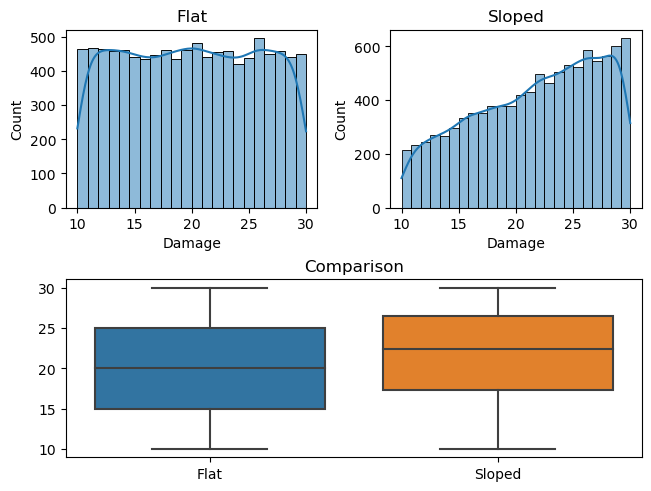

In [15]:
# Here we see how the damageTypeDatum class makes it easier to compare results
typeCount = len(damageTypeData)

fig = plt.figure(constrained_layout=True)
gs = GridSpec(2, typeCount, figure=fig)

combined_frame = pd.DataFrame()

currentIndex = 0
for damageType in damageTypeData:
    combined_frame[damageType.name] = damageType.data["Damage"]

    ax = fig.add_subplot(gs[0,currentIndex])
    ax.set_title(damageType.name)
    sns.histplot(data=damageType.data["Damage"], kde=True, ax=ax)

    currentIndex = currentIndex + 1

ax = fig.add_subplot(gs[1, :])
ax.set_title("Comparison")
sns.boxplot(data=combined_frame)

As we can see, the distribution of the sloped damage function is in fact sloped as expected, and produces higher damage on average than the flat function! It's working as expected!

This doesn't mean I'm done here though. With a first order pdf, my options for changing the damage distribution without changing the minimum and maximum damage are severely limited. In fact, this is it. This is the only possibility. This isn't great, as the whole point of this is to make the distribution skew towards higher damage as the player levels up. What can I do about this?

After some thinking, I've come to the conclusion that I can just change the order of the pdf. Instead of a first degree polynomial, it should be a polynomial to some degree $g \in \real_0^+$. The thinking behind this is that I can change g to change the curve of the pdf, which will move the average damage up and down. However, after doing some math exploring this, I came to the conclusion that it was a bit more trouble than I'd like, as there would be an edge case where $g=-1$, where I'd have to write a special version of the formula using a log function, and I felt it could be cleaner.

Upon consideration, I have decided to use the following, simplified formula:

$$D_r=d + r^g*(D-d)$$

Which relies on the fact that $r \in [0, 1)$, and the fact that $x^g \in [0, 1]$ for all values of x such that $x \in [0, 1]$ to ensure that all values generated are in the proper range, and that changes to g only change the distribution of the generated values. The result is that the same effect is achieved, a distribution I can easily change to make the average value lower or higher, and now there is no discontinuity problem to worry about.

That's not to say there are no problems, however. This new formula is such that the average damage increases as g approaches 0, which isn't a problem in and of itself. The issue is that the value of g such that all numbers in the range are equally likely is 1. This means that from 1 to 0, the average damage increases rapidly, but it decreases slowly on the interval from 1 to infinity. I will have to keep this in mind when I eventually come up with a formula to get g as a function of player level.

What follows is an analysis of the damage curves for different values of g.

In [16]:
def LerpPowerDamageFunction(roll, minDamage, maxDamage, g):
    return minDamage + np.power(roll, g) * (maxDamage - minDamage)

In [17]:
damageTypeData = []

frame = runAnalysis(LerpPowerDamageFunction, [10, 30, 0.1])
damageTypeData.append(DamageTypeDatum("g=0.1", frame))

frame = runAnalysis(LerpPowerDamageFunction, [10, 30, 1/4])
damageTypeData.append(DamageTypeDatum("g=0.25", frame))

frame = runAnalysis(LerpPowerDamageFunction, [10, 30, 1/2])
damageTypeData.append(DamageTypeDatum("g=0.5", frame))

frame = runAnalysis(LerpPowerDamageFunction, [10, 30, 0.75])
damageTypeData.append(DamageTypeDatum("g=0.75", frame))

frame = runAnalysis(LerpPowerDamageFunction, [10, 30, 0.85])
damageTypeData.append(DamageTypeDatum("g=0.85", frame))

frame = runAnalysis(LerpPowerDamageFunction, [10, 30, 1])
damageTypeData.append(DamageTypeDatum("g=1", frame))

frame = runAnalysis(LerpPowerDamageFunction, [10, 30, 1.25])
damageTypeData.append(DamageTypeDatum("g=1.25", frame))

frame = runAnalysis(LerpPowerDamageFunction, [10, 30, 2])
damageTypeData.append(DamageTypeDatum("g=2", frame))

<AxesSubplot:title={'center':'Comparison'}>

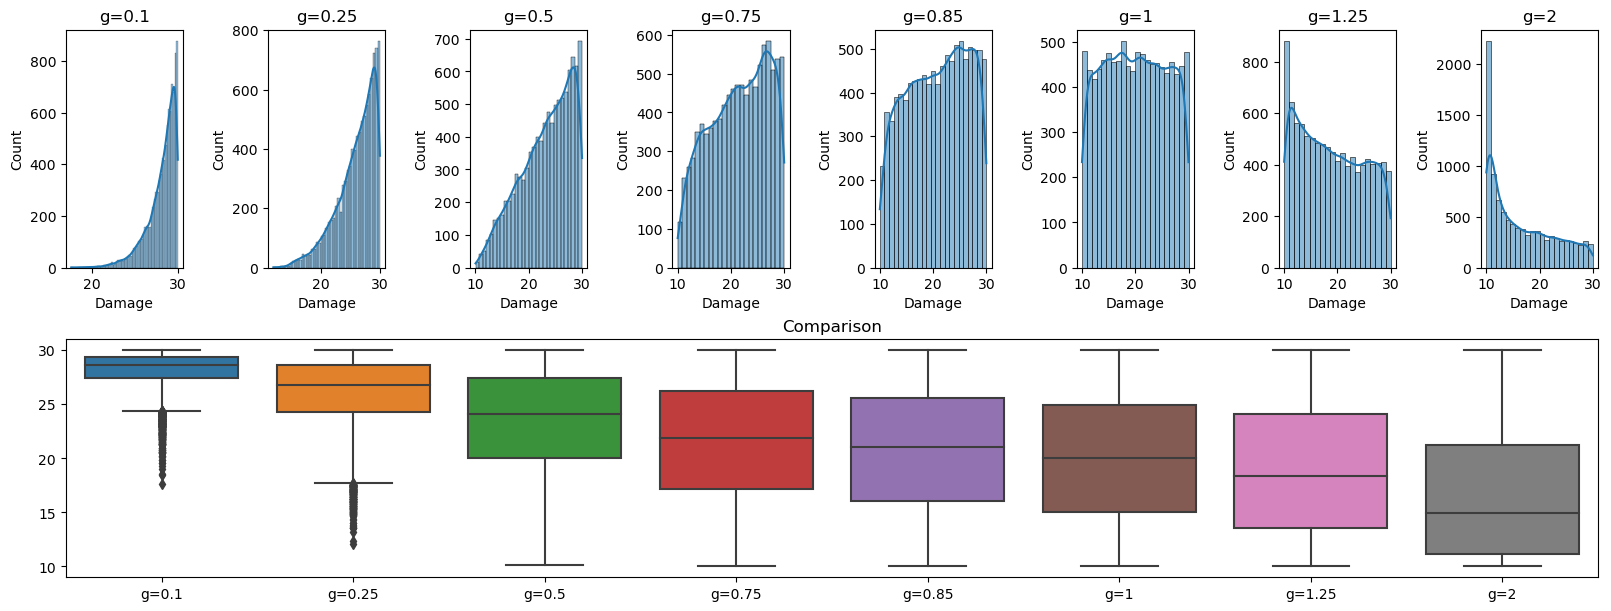

In [18]:
typeCount = len(damageTypeData)

fig = plt.figure(constrained_layout=True, figsize=(16, 6))
gs = GridSpec(2, typeCount, figure=fig)

combined_frame = pd.DataFrame()

currentIndex = 0
for damageType in damageTypeData:
    combined_frame[damageType.name] = damageType.data["Damage"]

    ax = fig.add_subplot(gs[0,currentIndex])
    ax.set_title(damageType.name)
    sns.histplot(data=damageType.data["Damage"], kde=True, ax=ax)

    currentIndex = currentIndex + 1

ax = fig.add_subplot(gs[1, :])
ax.set_title("Comparison")
sns.boxplot(data=combined_frame)